In [1]:
import numpy as np
import cupy as cp
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from numba import njit
import time


In [2]:
@njit
def mirror_cpu(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = np.zeros((nlin, ncol), dtype=A.dtype)

    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]

    return B


In [3]:
@njit
def NLM_fast_cpu(img, h, f, t):
    m, n = img.shape
    filtrada = np.zeros((m, n), dtype=img.dtype)
    img_n = mirror_cpu(img, f)
    for i in range(m):
        for j in range(n):
            im = i + f
            jn = j + f
            W1 = img_n[im-f:im+f+1, jn-f:jn+f+1]
            rmin = max(im-t, f)
            rmax = min(im+t, m+f-1)
            smin = max(jn-t, f)
            smax = min(jn+t, n+f-1)
            NL = 0.0
            Z = 0.0
            for r in range(rmin, rmax+1):
                for s in range(smin, smax+1):
                    W2 = img_n[r-f:r+f+1, s-f:s+f+1]
                    d2 = np.sum((W1 - W2)**2)
                    sij = np.exp(-d2/(h**2))
                    Z += sij
                    NL += sij * img_n[r, s]
            filtrada[i, j] = NL / Z
    return filtrada


In [4]:
def mirror_gpu(A, f):
    n, m = A.shape
    B = cp.zeros((n + 2*f, m + 2*f), dtype=A.dtype)
    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]
    return B


In [5]:
nlm_kernel_global_code = r'''
extern "C" __global__
void nlm_kernel_global(
    const float* img_n, float* output,
    int m, int n, int f, int t, float h, int padded_width
) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= m || j >= n)
        return;

    int im = i + f;
    int jm = j + f;

    float NL = 0.0f;
    float Z = 0.0f;

    for (int r = im - t; r <= im + t; ++r) {
        for (int s = jm - t; s <= jm + t; ++s) {
            float d2 = 0.0f;
            for (int u = -f; u <= f; ++u) {
                for (int v = -f; v <= f; ++v) {
                    int x1 = im + u;
                    int y1 = jm + v;
                    int x2 = r + u;
                    int y2 = s + v;

                    float val1 = img_n[x1 * padded_width + y1];
                    float val2 = img_n[x2 * padded_width + y2];
                    float diff = val1 - val2;
                    d2 += diff * diff;
                }
            }
            float weight = __expf(-d2 / (h * h));
            Z += weight;
            NL += weight * img_n[r * padded_width + s];
        }
    }

    output[i * n + j] = NL / Z;
}
'''



In [6]:
def NLM_fast_cuda_global(img, h, f, t):
    img = img.astype(cp.float32)
    m, n = img.shape
    padded = mirror_gpu(img, f)

    module = cp.RawModule(code=nlm_kernel_global_code, options=('-std=c++11',))
    kernel = module.get_function("nlm_kernel_global")

    output = cp.zeros((m, n), dtype=cp.float32)
    threads_per_block = (16, 16)
    grid = ((n + 15) // 16, (m + 15) // 16)

    kernel(
        grid, threads_per_block,
        (
            padded.ravel(), output.ravel(),
            cp.int32(m), cp.int32(n), cp.int32(f), cp.int32(t),
            cp.float32(h), cp.int32(padded.shape[1])
        )
    )
    return output

def add_noise_gaussian(img):
    m, n = img.shape
    sigma = 10
    noise = np.random.normal(0, sigma, (m, n)).astype(np.float32)
    noised = np.clip(img + noise, 0, 255)
    return noised

def add_poisson_noise(img):    
    poisson_img = np.random.poisson(img)    
    return poisson_img

def add_poisson_gaussian_noise(image, gaussian_sigma=25):
    # Apply Poisson noise
    poisson_image = np.random.poisson(image)

    # Apply Gaussian noise
    gaussian_noise = np.random.normal(loc=0.0, scale=gaussian_sigma, size=image.shape)
    noisy_image = poisson_image + gaussian_noise 

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def downscale(img):
    img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
    return img_downscale

def anscombe_transform(img):
    return 2.0 * np.sqrt(img.astype(np.float32) + 3.0 / 8.0)

def inverse_anscombe(y):
    # Inversa exata de Makitalo & Foi (IEEE T-IP 2011)
    return ((y / 2.0)**2) - 3.0 / 8.0

def compute_adaptive_q(sigma_est, anscombe=False):
    q_nlm = 0.8 + 0.5 * np.tanh(0.3 * (sigma_est - 1))
    q_geo = 1.0 + 0.7 * np.tanh(0.25 * (sigma_est - 1.5))

    if anscombe:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 10)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 10)
    else:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 100)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 100)

    print(f'q_nlm: {q_nlm}, g_geo: {q_geo}')
    return q_nlm, q_geo

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def select_best_h_using_adaptive_q(image_downscale, image_gpu, q_nlm_candidates, f, t, alpha=0.5, anscombe=False):
    melhor_score = -float('inf')
    melhor_q_nlm = None
    melhor_resultado = None
    melhor_psnr = None
    melhor_ssim = None

    for h_nlm in q_nlm_candidates:
        print(f'h_nlm: {h_nlm}')

        # Aplica NLM
        result_gpu = NLM_fast_cuda_global(image_gpu, h_nlm, f, t)
        cp.cuda.Stream.null.synchronize()

        # Referência: imagem original
        img_ref = np.clip(image_downscale, 0, 255).astype(np.uint8)

        if anscombe:
            # Inversa de Anscombe
            result_processed = np.maximum(inverse_anscombe(cp.asnumpy(result_gpu)), 0)
        else:
            result_processed = cp.asnumpy(result_gpu)

        result_uint8 = np.clip(result_processed, 0, 255).astype(np.uint8)

        # Métricas
        psnr = peak_signal_noise_ratio(img_ref, result_uint8, data_range=255)
        ssim = structural_similarity(img_ref, result_uint8, data_range=255)

        # Score combinado
        score = alpha * psnr + (1 - alpha) * (ssim * 100)
        print(f"h = {h_nlm:.2f} | PSNR = {psnr:.2f} | SSIM = {ssim:.4f} | Score = {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_q_nlm = h_nlm
            melhor_resultado = result_processed
            melhor_psnr = psnr
            melhor_ssim = ssim

    print(f"\n[SELECIONADO] q_nlm = {melhor_q_nlm:.2f} | PSNR = {melhor_psnr:.2f} | SSIM = {melhor_ssim:.4f}")

    return melhor_resultado, melhor_q_nlm, melhor_psnr, melhor_ssim


### Testando

Tempo CPU: 9.02252984046936
Tempo GPU: 0.24392962455749512
Diferença média: 0.0169
Diferença máxima: 4.0845

--- Métricas de Qualidade ---
PSNR (CPU NLM):  33.42 dB
PSNR (CUDA NLM): 33.42 dB
SSIM (CPU NLM):  0.9134
SSIM (CUDA NLM): 0.9134


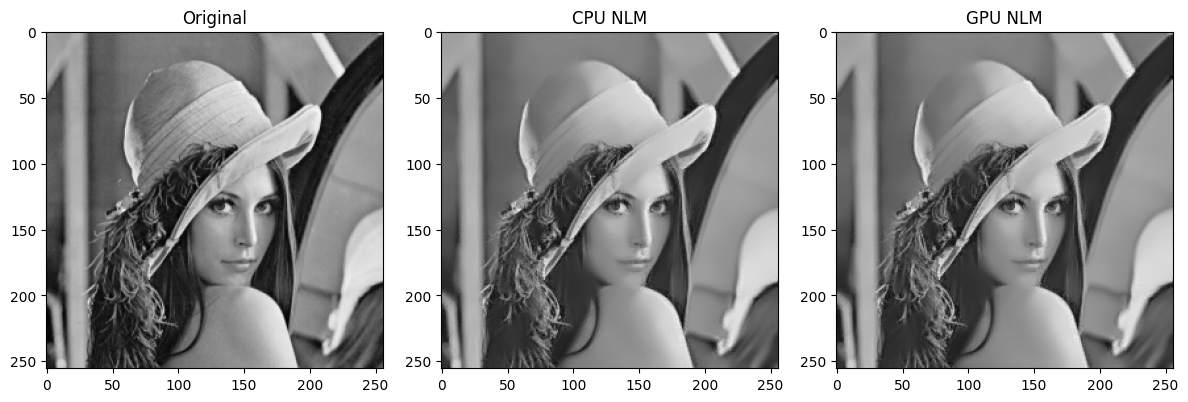

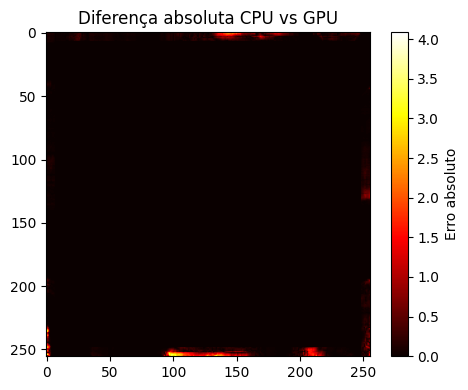

In [7]:
# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape
sigma = 10
ruido = np.random.normal(0, sigma, (m, n)).astype(np.float32)
ruidosa = np.clip(img_downscale + ruido, 0, 255)

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
img_gpu = cp.array(img_cpu)

# Parâmetros do filtro
h = 110
f = 4
t = 7

# ------------------------------- CPU -------------------------------
start_cpu = time.time()
result_cpu = NLM_fast_cpu(img_cpu, h, f, t)
print("Tempo CPU:", time.time() - start_cpu)

# ------------------------------- GPU -------------------------------
start_gpu = time.time()
result_gpu = NLM_fast_cuda_global(img_gpu, h, f, t)
cp.cuda.Stream.null.synchronize()
print("Tempo GPU:", time.time() - start_gpu)

# Comparação
result_gpu_cpu = cp.asnumpy(result_gpu)
diff = np.abs(result_cpu - result_gpu_cpu)
print(f'Diferença média: {diff.mean():.4f}')
print(f'Diferença máxima: {diff.max():.4f}')

# Métricas PSNR e SSIM em relação à imagem original
img_ref = np.clip(img_downscale, 0, 255).astype(np.uint8)
result_cpu_uint8 = np.clip(result_cpu, 0, 255).astype(np.uint8)
result_gpu_uint8 = np.clip(result_gpu_cpu, 0, 255).astype(np.uint8)

psnr_cpu = peak_signal_noise_ratio(img_ref, result_cpu_uint8, data_range=255)
psnr_gpu = peak_signal_noise_ratio(img_ref, result_gpu_uint8, data_range=255)
ssim_cpu = structural_similarity(img_ref, result_cpu_uint8, data_range=255)
ssim_gpu = structural_similarity(img_ref, result_gpu_uint8, data_range=255)

print(f'\n--- Métricas de Qualidade ---')
print(f'PSNR (CPU NLM):  {psnr_cpu:.2f} dB')
print(f'PSNR (CUDA NLM): {psnr_gpu:.2f} dB')
print(f'SSIM (CPU NLM):  {ssim_cpu:.4f}')
print(f'SSIM (CUDA NLM): {ssim_gpu:.4f}')

# Visualizações
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Original"); plt.imshow(img_ref, cmap='gray')
plt.subplot(1,3,2); plt.title("CPU NLM"); plt.imshow(result_cpu, cmap='gray')
plt.subplot(1,3,3); plt.title("GPU NLM"); plt.imshow(result_gpu_cpu, cmap='gray')
plt.tight_layout(); plt.show()

# Diferença absoluta entre CPU e GPU
plt.figure(figsize=(5,4))
plt.title("Diferença absoluta CPU vs GPU")
plt.imshow(diff, cmap='hot')
plt.colorbar(label='Erro absoluto')
plt.tight_layout()
plt.show()

In [8]:
from skimage.io import imsave
imsave("cpu_result.png", np.clip(result_cpu, 0, 255).astype(np.uint8))
imsave("gpu_result.png", np.clip(result_gpu_cpu, 0, 255).astype(np.uint8))
imsave("abs_diff.png", np.clip(diff * 10, 0, 255).astype(np.uint8))

/tmp/ipykernel_763/708413431.py:4: UserWarning: abs_diff.png is a low contrast image
  imsave("abs_diff.png", np.clip(diff * 10, 0, 255).astype(np.uint8))


### Noise Gaussian

In [9]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape
sigma = 10
ruido = np.random.normal(0, sigma, (m, n)).astype(np.float32)
ruidosa = np.clip(img_downscale + ruido, 0, 255)

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
estimated_sigma = estimate_sigma(img_cpu)
img_gpu = cp.array(img_cpu)


h_nlm , g_nlm = compute_adaptive_q(estimated_sigma)

q_nlm_candidates = np.array([h_nlm + delta for delta in range(-50, 25, 1)])

print(f'q_nlm_candidates: {q_nlm_candidates}')
# Parâmetros do filtro

q_nlm: 129, g_geo: 168
q_nlm_candidates: [ 79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114
 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153]


In [10]:
melhor_img, melhor_h, melhor_psnr, melhor_ssim = select_best_h_using_adaptive_q(
    image_downscale=img_downscale,
    image_gpu=img_gpu,
    q_nlm_candidates=q_nlm_candidates,
    f=3, t=7,
    alpha=0.5,
    anscombe=False
)

h_nlm: 79
h = 79.00 | PSNR = 33.42 | SSIM = 0.9174 | Score = 62.58
h_nlm: 80
h = 80.00 | PSNR = 33.44 | SSIM = 0.9169 | Score = 62.56
h_nlm: 81
h = 81.00 | PSNR = 33.45 | SSIM = 0.9164 | Score = 62.55
h_nlm: 82
h = 82.00 | PSNR = 33.46 | SSIM = 0.9158 | Score = 62.52
h_nlm: 83
h = 83.00 | PSNR = 33.47 | SSIM = 0.9152 | Score = 62.50
h_nlm: 84
h = 84.00 | PSNR = 33.47 | SSIM = 0.9146 | Score = 62.46
h_nlm: 85
h = 85.00 | PSNR = 33.47 | SSIM = 0.9139 | Score = 62.43
h_nlm: 86
h = 86.00 | PSNR = 33.47 | SSIM = 0.9132 | Score = 62.40
h_nlm: 87
h = 87.00 | PSNR = 33.47 | SSIM = 0.9125 | Score = 62.36
h_nlm: 88
h = 88.00 | PSNR = 33.45 | SSIM = 0.9117 | Score = 62.31
h_nlm: 89
h = 89.00 | PSNR = 33.44 | SSIM = 0.9111 | Score = 62.28
h_nlm: 90
h = 90.00 | PSNR = 33.42 | SSIM = 0.9102 | Score = 62.22
h_nlm: 91
h = 91.00 | PSNR = 33.40 | SSIM = 0.9094 | Score = 62.17
h_nlm: 92
h = 92.00 | PSNR = 33.38 | SSIM = 0.9086 | Score = 62.12
h_nlm: 93
h = 93.00 | PSNR = 33.35 | SSIM = 0.9077 | Score = 6

### Noise Poisson

In [11]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape

ruidosa = add_poisson_noise(img_downscale)
print(f'ruidosa: {type(ruidosa)}')

# Preparo para CPU e GPU
img_cpu = ruidosa.astype(np.float32)
print(f'img_cpu: {type(img_cpu)}')
estimated_sigma = estimate_sigma(img_cpu)
print(f'estimated_sigma: {(estimated_sigma)}')
img_gpu = cp.array(img_cpu)
print(f'img_gpu: {type(img_gpu)}')


h_nlm , g_nlm = compute_adaptive_q(estimated_sigma)

q_nlm_candidates_poisson = np.array([h_nlm + delta for delta in range(-30, 30, 1)])

print(f'q_nlm_candidates: {q_nlm_candidates_poisson}')
# Parâmetros do filtro

ruidosa: <class 'numpy.ndarray'>
img_cpu: <class 'numpy.ndarray'>
estimated_sigma: 11.401894775297531
img_gpu: <class 'cupy.ndarray'>
q_nlm: 129, g_geo: 169
q_nlm_candidates: [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158]


In [12]:
melhor_img, melhor_h, melhor_psnr, melhor_ssim = select_best_h_using_adaptive_q(
    image_downscale=img_downscale,
    image_gpu=img_gpu,
    q_nlm_candidates=q_nlm_candidates_poisson,
    f=3, t=7,
    alpha=0.5,
    anscombe=False
)

h_nlm: 99
h = 99.00 | PSNR = 32.78 | SSIM = 0.8992 | Score = 61.35
h_nlm: 100
h = 100.00 | PSNR = 32.75 | SSIM = 0.8985 | Score = 61.30
h_nlm: 101
h = 101.00 | PSNR = 32.71 | SSIM = 0.8977 | Score = 61.24
h_nlm: 102
h = 102.00 | PSNR = 32.67 | SSIM = 0.8968 | Score = 61.18
h_nlm: 103
h = 103.00 | PSNR = 32.63 | SSIM = 0.8958 | Score = 61.11
h_nlm: 104
h = 104.00 | PSNR = 32.59 | SSIM = 0.8949 | Score = 61.04
h_nlm: 105
h = 105.00 | PSNR = 32.54 | SSIM = 0.8940 | Score = 60.97
h_nlm: 106
h = 106.00 | PSNR = 32.49 | SSIM = 0.8930 | Score = 60.90
h_nlm: 107
h = 107.00 | PSNR = 32.45 | SSIM = 0.8921 | Score = 60.83
h_nlm: 108
h = 108.00 | PSNR = 32.39 | SSIM = 0.8912 | Score = 60.76
h_nlm: 109
h = 109.00 | PSNR = 32.34 | SSIM = 0.8901 | Score = 60.67
h_nlm: 110
h = 110.00 | PSNR = 32.29 | SSIM = 0.8891 | Score = 60.60
h_nlm: 111
h = 111.00 | PSNR = 32.23 | SSIM = 0.8880 | Score = 60.52
h_nlm: 112
h = 112.00 | PSNR = 32.18 | SSIM = 0.8871 | Score = 60.44
h_nlm: 113
h = 113.00 | PSNR = 32.12

### Poisson com Anscombe

In [13]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/0.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale_poisson = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape

ruidosa = add_poisson_noise(img_downscale_poisson)
print(f'ruidosa: {type(ruidosa)}')

ruidosa_anscombe = anscombe_transform(ruidosa)
print(type(ruidosa_anscombe))

# Preparo para CPU e GPU
img_cpu = ruidosa_anscombe.astype(np.float32)
print(f'img_cpu: {type(img_cpu)}')
estimated_sigma = estimate_sigma(img_cpu, channel_axis=None)
print(f'estimated_sigma: {(estimated_sigma)}')
img_gpu = cp.array(img_cpu)
print(f'img_gpu: {type(img_gpu)}')

h_nlm, g_nlm = compute_adaptive_q(estimated_sigma, anscombe=True)

h_nlm, g_nlm = h_nlm, g_nlm

q_nlm_candidates_poisson_gaussian = np.array(
    [h_nlm + delta for delta in range(-10, 10, 1) if (h_nlm + delta) >= 1]
)

print(f'q_nlm_candidates_poisson_gaussian: {img_downscale_poisson, q_nlm_candidates_poisson_gaussian}')
# Parâmetros do filtro



ruidosa: <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
img_cpu: <class 'numpy.ndarray'>
estimated_sigma: 1.0683588418170313
img_gpu: <class 'cupy.ndarray'>
q_nlm: 8, g_geo: 9
q_nlm_candidates_poisson_gaussian: (array([[162.  , 161.5 , 159.5 , ..., 168.5 , 170.5 , 141.5 ],
       [162.  , 161.5 , 159.5 , ..., 168.5 , 170.5 , 141.5 ],
       [163.  , 159.  , 159.75, ..., 157.75, 151.  , 115.75],
       ...,
       [ 51.  ,  51.  ,  53.5 , ...,  81.  ,  92.5 ,  91.75],
       [ 44.5 ,  49.25,  50.5 , ...,  92.5 , 101.5 ,  98.  ],
       [ 44.  ,  56.75,  50.5 , ..., 100.5 , 102.  , 106.5 ]],
      dtype=float32), array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]))


In [14]:
melhor_img, melhor_h, melhor_psnr, melhor_ssim = select_best_h_using_adaptive_q(
    image_downscale=img_downscale,
    image_gpu=img_gpu,
    q_nlm_candidates=q_nlm_candidates_poisson_gaussian,
    f=3, t=7,
    alpha=0.5,
    anscombe=True
)


h_nlm: 1
h = 1.00 | PSNR = 27.22 | SSIM = 0.6667 | Score = 46.94
h_nlm: 2
h = 2.00 | PSNR = 27.25 | SSIM = 0.6681 | Score = 47.03
h_nlm: 3
h = 3.00 | PSNR = 27.45 | SSIM = 0.6758 | Score = 47.51
h_nlm: 4
h = 4.00 | PSNR = 28.31 | SSIM = 0.7212 | Score = 50.22
h_nlm: 5
h = 5.00 | PSNR = 30.50 | SSIM = 0.8453 | Score = 57.51
h_nlm: 6
h = 6.00 | PSNR = 32.07 | SSIM = 0.9045 | Score = 61.26
h_nlm: 7
h = 7.00 | PSNR = 32.91 | SSIM = 0.9167 | Score = 62.29
h_nlm: 8
h = 8.00 | PSNR = 33.27 | SSIM = 0.9151 | Score = 62.39
h_nlm: 9
h = 9.00 | PSNR = 33.27 | SSIM = 0.9091 | Score = 62.09
h_nlm: 10
h = 10.00 | PSNR = 32.97 | SSIM = 0.9007 | Score = 61.52
h_nlm: 11
h = 11.00 | PSNR = 32.48 | SSIM = 0.8912 | Score = 60.80
h_nlm: 12
h = 12.00 | PSNR = 31.86 | SSIM = 0.8805 | Score = 59.96
h_nlm: 13
h = 13.00 | PSNR = 31.23 | SSIM = 0.8695 | Score = 59.09
h_nlm: 14
h = 14.00 | PSNR = 30.62 | SSIM = 0.8585 | Score = 58.23
h_nlm: 15
h = 15.00 | PSNR = 30.06 | SSIM = 0.8481 | Score = 57.43
h_nlm: 16
h =

### Poisson Gaussian Anscombe

In [15]:
from skimage.restoration import estimate_sigma

# ------------------------------- Execução principal -------------------------------

# Carregamento da imagem
img_path = '../images/4.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Downscale + ruído
img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
m, n = img_downscale.shape

ruidosa = add_poisson_gaussian_noise(img_downscale)
print(f'ruidosa: {type(ruidosa)}')

ruidosa_anscombe = anscombe_transform(ruidosa)
print(type(ruidosa_anscombe))

# Preparo para CPU e GPU
img_cpu = ruidosa_anscombe.astype(np.float32)
print(f'img_cpu: {type(img_cpu)}')
estimated_sigma = estimate_sigma(img_cpu)# channel_axis=None)
print(f'estimated_sigma: {(estimated_sigma)}')
img_gpu = cp.array(img_cpu)
print(f'img_gpu: {type(img_gpu)}')


h_nlm, g_nlm = compute_adaptive_q(estimated_sigma, anscombe=True)

q_nlm_candidates_poisson_gaussian = np.array(
    [h_nlm + delta for delta in range(-30, 30, 1) if (h_nlm + delta) >= 1]
)

print(f'q_nlm_candidates_poisson_gaussian: {q_nlm_candidates_poisson_gaussian}')

ruidosa: <class 'numpy.ndarray'>
<class 'numpy.ndarray'>
img_cpu: <class 'numpy.ndarray'>
estimated_sigma: 3.1446488689900463
img_gpu: <class 'cupy.ndarray'>
q_nlm: 10, g_geo: 12
q_nlm_candidates_poisson_gaussian: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]


In [16]:
melhor_img, melhor_h, melhor_psnr, melhor_ssim = select_best_h_using_adaptive_q(
    image_downscale=img_downscale,
    image_gpu=img_gpu,
    q_nlm_candidates=q_nlm_candidates_poisson_gaussian,
    f=3, t=7,
    alpha=0.5,
    anscombe=True
)


h_nlm: 1
h = 1.00 | PSNR = 19.76 | SSIM = 0.3664 | Score = 28.20
h_nlm: 2
h = 2.00 | PSNR = 19.76 | SSIM = 0.3664 | Score = 28.20
h_nlm: 3
h = 3.00 | PSNR = 19.76 | SSIM = 0.3664 | Score = 28.20
h_nlm: 4
h = 4.00 | PSNR = 19.76 | SSIM = 0.3664 | Score = 28.20
h_nlm: 5
h = 5.00 | PSNR = 19.77 | SSIM = 0.3665 | Score = 28.21
h_nlm: 6
h = 6.00 | PSNR = 19.79 | SSIM = 0.3673 | Score = 28.26
h_nlm: 7
h = 7.00 | PSNR = 19.83 | SSIM = 0.3687 | Score = 28.35
h_nlm: 8
h = 8.00 | PSNR = 19.86 | SSIM = 0.3697 | Score = 28.42
h_nlm: 9
h = 9.00 | PSNR = 19.91 | SSIM = 0.3716 | Score = 28.54
h_nlm: 10
h = 10.00 | PSNR = 20.06 | SSIM = 0.3775 | Score = 28.90
h_nlm: 11
h = 11.00 | PSNR = 20.39 | SSIM = 0.3916 | Score = 29.77
h_nlm: 12
h = 12.00 | PSNR = 20.93 | SSIM = 0.4166 | Score = 31.30
h_nlm: 13
h = 13.00 | PSNR = 21.68 | SSIM = 0.4519 | Score = 33.43
h_nlm: 14
h = 14.00 | PSNR = 22.54 | SSIM = 0.4924 | Score = 35.89
h_nlm: 15
h = 15.00 | PSNR = 23.42 | SSIM = 0.5316 | Score = 38.29
h_nlm: 16
h =

In [17]:
# Carregamento da imagem
img_path = '../images/1.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

img_downscale = downscale(img)

img_noise_gaussian = add_noise_gaussian(img_downscale)

img_noise_poisson = add_poisson_noise(img_downscale)
noised_anscombe_poisson = anscombe_transform(img_noise_poisson)

img_noise_poisson_gaussian = add_poisson_gaussian_noise(img_downscale)
noised_anscombe_poisson_gaussian = anscombe_transform(img_noise_poisson_gaussian)

# Gaussian
img_cpu_gaussian = img_noise_gaussian.astype(np.float32)
print(f'img_cpu_gaussian: {type(img_cpu_gaussian)}')

estimated_sigma_gaussian = estimate_sigma(img_cpu_gaussian)# channel_axis=None)
print(f'estimated_sigma_gaussian: {(estimated_sigma_gaussian)}')
img_gpu_gaussian = cp.array(img_cpu_gaussian)
print(f'img_gpu_gaussian: {type(img_gpu_gaussian)}')

h_nlm_gaussian, g_nlm_gaussian = compute_adaptive_q(estimated_sigma_gaussian)

q_nlm_candidates_gaussian = np.array(
    [h_nlm_gaussian + delta for delta in range(-30, 30, 1) if (h_nlm_gaussian + delta) >= 1]
)

#print(f'q_nlm_candidates: {q_nlm_candidates_gaussian}')

h_nlm_final_gaussian =  select_best_h_using_adaptive_q(img_downscale, img_gpu_gaussian, q_nlm_candidates_gaussian, f=4, t=7, alpha=0.5)


# Poisson
img_cpu_poisson = noised_anscombe_poisson.astype(np.float32)
print(f'img_cpu_poisson: {type(img_cpu_poisson)}')

estimated_sigma_poisson = estimate_sigma(img_cpu_poisson, anscombe=True)
print(f'estimated_sigma_poisson: {(estimated_sigma_poisson)}')
img_gpu_poisson = cp.array(img_cpu_poisson)
print(f'img_gpu_poisson: {type(img_gpu_poisson)}')

h_nlm_poisson, g_nlm_poisson = compute_adaptive_q(estimated_sigma_poisson, anscombe=True)

q_nlm_candidates_poisson = np.array(
    [h_nlm_poisson + delta for delta in range(-30, 30, 1) if (h_nlm_poisson + delta) >= 1]
)

#print(f'q_nlm_candidates: {q_nlm_candidates_poisson}')

h_nlm_final_poisson =  select_best_h_using_adaptive_q(img_downscale, img_gpu_poisson, q_nlm_candidates_poisson, f=4, t=7, alpha=0.5, anscombe=True)


# Poisson Gaussian
img_cpu_poisson_gaussian = noised_anscombe_poisson_gaussian.astype(np.float32)
print(f'img_cpu_poisson_gaussian: {type(img_cpu_poisson_gaussian)}')

estimated_sigma_poisson_gaussian = estimate_sigma(img_cpu_poisson_gaussian, anscombe=True)# channel_axis=None)
print(f'estimated_sigma_poisson_gaussian: {(estimated_sigma_poisson_gaussian)}')
img_gpu_poisson_gaussian = cp.array(img_cpu_poisson_gaussian)
print(f'img_gpu_poisson_gaussian: {type(img_gpu_poisson_gaussian)}')

h_nlm_poisson_gaussian, g_nlm_poisson_gaussian = compute_adaptive_q(estimated_sigma_poisson_gaussian, anscombe=True)

q_nlm_candidates_poisson_gaussian = np.array(
    [h_nlm_poisson_gaussian + delta for delta in range(-30, 30, 1) if (h_nlm_poisson_gaussian + delta) >= 1]
)

#print(f'q_nlm_candidates: {q_nlm_candidates_poisson_gaussian}')

melhor_img, melhor_h, melhor_psnr, melhor_ssim = select_best_h_using_adaptive_q(
    image_downscale=img_downscale,
    image_gpu=img_gpu,
    q_nlm_candidates=q_nlm_candidates_poisson_gaussian,
    f=4, t=7,
    alpha=0.5,
    anscombe=True
)




img_cpu_gaussian: <class 'numpy.ndarray'>
estimated_sigma_gaussian: 12.292450657487793
img_gpu_gaussian: <class 'cupy.ndarray'>
q_nlm: 129, g_geo: 169
h_nlm: 99
h = 99.00 | PSNR = 31.81 | SSIM = 0.9192 | Score = 61.86
h_nlm: 100
h = 100.00 | PSNR = 31.84 | SSIM = 0.9190 | Score = 61.87
h_nlm: 101
h = 101.00 | PSNR = 31.87 | SSIM = 0.9188 | Score = 61.88
h_nlm: 102
h = 102.00 | PSNR = 31.90 | SSIM = 0.9186 | Score = 61.88
h_nlm: 103
h = 103.00 | PSNR = 31.92 | SSIM = 0.9182 | Score = 61.87
h_nlm: 104
h = 104.00 | PSNR = 31.94 | SSIM = 0.9178 | Score = 61.86
h_nlm: 105
h = 105.00 | PSNR = 31.96 | SSIM = 0.9174 | Score = 61.85
h_nlm: 106
h = 106.00 | PSNR = 31.98 | SSIM = 0.9169 | Score = 61.84
h_nlm: 107
h = 107.00 | PSNR = 31.99 | SSIM = 0.9165 | Score = 61.82
h_nlm: 108
h = 108.00 | PSNR = 32.00 | SSIM = 0.9159 | Score = 61.80
h_nlm: 109
h = 109.00 | PSNR = 32.00 | SSIM = 0.9152 | Score = 61.76
h_nlm: 110
h = 110.00 | PSNR = 32.01 | SSIM = 0.9146 | Score = 61.73
h_nlm: 111
h = 111.00 |

TypeError: estimate_sigma() got an unexpected keyword argument 'anscombe'

In [ ]:
def pipeline_filtragem_nlm(params):
    """
    Executa o pipeline completo de:
    - aplicação de ruído (gaussian, poisson, poisson_gaussian),
    - transformada de Anscombe (se necessário),
    - estimativa de sigma,
    - escolha adaptativa de h,
    - filtragem com NLM CUDA.

    Parâmetros esperados no dicionário 'params':
    - img_path: str
    - tipo_ruido: 'gaussian', 'poisson' ou 'poisson_gaussian'
    - f: int (tamanho do patch)
    - t: int (janela de busca)
    - alpha: float (peso entre PSNR e SSIM)
    - gaussian_sigma: float (para ruído Poisson-Gaussiano)
    """
    import skimage.io
    import skimage.color
    from skimage.transform import downscale_local_mean
    import numpy as np
    import cupy as cp
    from skimage.restoration import estimate_sigma
    from skimage.metrics import peak_signal_noise_ratio, structural_similarity

    # Carregamento da imagem
    img = skimage.io.imread(params["img_path"])
    img = img[0, :, :] if len(img.shape) > 2 else img
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)
        img = 255 * img

    img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)

    tipo_ruido = params["tipo_ruido"]
    f, t = params.get("f", 4), params.get("t", 7)
    alpha = params.get("alpha", 0.5)

    # Aplicação do ruído + Anscombe
    if tipo_ruido == "gaussian":
        img_noisy = add_noise_gaussian(img_downscale)
        img_cpu = img_noisy.astype(np.float32)
        anscombe = False
    elif tipo_ruido == "poisson":
        img_noisy = add_poisson_noise(img_downscale)
        img_cpu = anscombe_transform(img_noisy).astype(np.float32)
        anscombe = True
    elif tipo_ruido == "poisson_gaussian":
        sigma = params.get("gaussian_sigma", 25)
        img_noisy = add_poisson_gaussian_noise(img_downscale, gaussian_sigma=sigma)
        img_cpu = anscombe_transform(img_noisy).astype(np.float32)
        anscombe = True
    else:
        raise ValueError("Tipo de ruído inválido. Use 'gaussian', 'poisson' ou 'poisson_gaussian'.")

    # Estimativa de sigma
    estimated_sigma = estimate_sigma(img_cpu)
    h_nlm, _ = compute_adaptive_q(estimated_sigma, anscombe=anscombe)

    # Geração dos candidatos a h
    q_nlm_candidates = np.array(
        [h_nlm + delta for delta in range(-30, 30, 1) if (h_nlm + delta) >= 1]
    )

    img_gpu = cp.array(img_cpu)

    # Seleção do melhor h
    melhor_img, melhor_h, melhor_psnr, melhor_ssim = select_best_h_using_adaptive_q(
        image_downscale=img_downscale,
        image_gpu=img_gpu,
        q_nlm_candidates=q_nlm_candidates,
        f=f, t=t,
        alpha=alpha,
        anscombe=anscombe
    )

    return {
        "imagem_filtrada": melhor_img,
        "melhor_h": melhor_h,
        "psnr": melhor_psnr,
        "ssim": melhor_ssim,
        "imagem_ruidosa": img_noisy,
        "imagem_original": img_downscale
    }


In [ ]:
resultados = pipeline_filtragem_nlm({
    "img_path": "../images/1.gif",
    "tipo_ruido": "gaussian",
    "f": 4,
    "t": 7,
    "alpha": 0.5,
    "gaussian_sigma": 20
})

# Acessar resultados:
img_filtrada = resultados["imagem_filtrada"]
print(f"PSNR: {resultados['psnr']:.2f}, SSIM: {resultados['ssim']:.4f}, h*: {resultados['melhor_h']}")


q_nlm: 129, g_geo: 169
h_nlm: 99
h = 99.00 | PSNR = 31.97 | SSIM = 0.9212 | Score = 62.04
h_nlm: 100
h = 100.00 | PSNR = 32.00 | SSIM = 0.9210 | Score = 62.05
h_nlm: 101
h = 101.00 | PSNR = 32.03 | SSIM = 0.9208 | Score = 62.06
h_nlm: 102
h = 102.00 | PSNR = 32.06 | SSIM = 0.9205 | Score = 62.06
h_nlm: 103
h = 103.00 | PSNR = 32.08 | SSIM = 0.9201 | Score = 62.05
h_nlm: 104
h = 104.00 | PSNR = 32.10 | SSIM = 0.9198 | Score = 62.04
h_nlm: 105
h = 105.00 | PSNR = 32.12 | SSIM = 0.9193 | Score = 62.03
h_nlm: 106
h = 106.00 | PSNR = 32.13 | SSIM = 0.9188 | Score = 62.01
h_nlm: 107
h = 107.00 | PSNR = 32.14 | SSIM = 0.9182 | Score = 61.98
h_nlm: 108
h = 108.00 | PSNR = 32.15 | SSIM = 0.9176 | Score = 61.96
h_nlm: 109
h = 109.00 | PSNR = 32.15 | SSIM = 0.9169 | Score = 61.92
h_nlm: 110
h = 110.00 | PSNR = 32.16 | SSIM = 0.9162 | Score = 61.89
h_nlm: 111
h = 111.00 | PSNR = 32.16 | SSIM = 0.9155 | Score = 61.85
h_nlm: 112
h = 112.00 | PSNR = 32.15 | SSIM = 0.9147 | Score = 61.81
h_nlm: 113
h 

### Paralel

In [19]:
import sklearn.neighbors as sknn
import networkx as nx

def process_pixel(i, j, img_n, f, t, h, nn, m, n):
    im = i + f
    jn = j + f
    patch_central = img_n[im - f:im + f + 1, jn - f:jn + f + 1]
    central = patch_central.ravel()

    rmin = max(im - t, f)
    rmax = min(im + t, m + f)
    smin = max(jn - t, f)
    smax = min(jn + t, n + f)

    n_patches = (rmax - rmin) * (smax - smin)
    patch_size = (2 * f + 1) ** 2

    dataset = np.empty((n_patches, patch_size), dtype=np.float32)
    pixels_busca = np.empty(n_patches, dtype=np.float32)

    source = -1
    k = 0
    for r in range(rmin, rmax):
        for s in range(smin, smax):
            W = img_n[r - f:r + f + 1, s - f:s + f + 1]
            neighbor = W.ravel()
            dataset[k, :] = neighbor
            pixels_busca[k] = img_n[r, s]
            if np.array_equal(central, neighbor):
                source = k
            k += 1

    if source == -1:
        source = 0  # fallback para evitar erro

    knnGraph = sknn.kneighbors_graph(dataset, n_neighbors=nn, mode='distance')
    G = nx.from_scipy_sparse_array(knnGraph)
    length, _ = nx.single_source_dijkstra(G, source)

    points = list(length.keys())
    distancias = np.array(list(length.values()), dtype=np.float32)

    similaridades = np.exp(-distancias ** 2 / (h ** 2))
    pixels = pixels_busca[points]

    NL = np.sum(similaridades * pixels)
    Z = np.sum(similaridades)
    return NL / Z if Z > 0 else img_n[im, jn]


from joblib import Parallel, delayed

def Parallel_GEONLM(img_n, f, t, h, nn):
    print(f'img_n.shape: {img_n.shape}')
    m = img_n.shape[0] - 2 * f
    n = img_n.shape[1] - 2 * f
    print(f'M: {m}, N: {n}')

    filtrada = Parallel(n_jobs=-1)(
        delayed(process_pixel)(i, j, img_n, f, t, h, nn, m, n)
        for i in range(m)
        for j in range(n)
    )

    filtrada_geo = np.array(filtrada, dtype=np.float32).reshape((m, n))
    return filtrada_geo


In [ ]:
import numpy as np
import skimage.io
import skimage.color
from skimage.restoration import estimate_sigma
from skimage.transform import downscale_local_mean
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

# Assuma que essas funções estão definidas:
# - downscale
# - mirror_cpu
# - add_noise_gaussian
# - compute_adaptive_q
# - Parallel_GEONLM (otimizada)
# - process_pixel (otimizada)

def run_geonlm_pipeline(img_original, img_noisy, f, t, h_base, nn=10, h_multipliers=[1, 1.05, 1.10, 1.15, 1.2, 1.23, 1.25,1.35]):
    melhor_score = -np.inf
    melhor_img = None
    melhor_h = None
    melhor_psnr = None
    melhor_ssim = None

    for mult in h_multipliers:
        h_geo = h_base * mult
        print(f"\nExecutando GEONLM com h = {h_geo:.2f} (base {h_base} * {mult})")

        img_geo = Parallel_GEONLM(img_noisy, f=f, t=t, h=h_geo, nn=nn)

        img_ref = np.clip(img_original, 0, 255).astype(np.uint8)
        img_geo_uint8 = np.clip(img_geo, 0, 255).astype(np.uint8)

        psnr = peak_signal_noise_ratio(img_ref, img_geo_uint8, data_range=255)
        ssim = structural_similarity(img_ref, img_geo_uint8, data_range=255)

        score = 0.5 * psnr + 0.5 * (ssim * 100)
        print(f"→ PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, Score: {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_img = img_geo
            melhor_h = h_geo
            melhor_psnr = psnr
            melhor_ssim = ssim

    print(f"\n[FINAL] Melhor h: {melhor_h:.2f}, PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}")
    return melhor_img, melhor_h, melhor_psnr, melhor_ssim


# ------------------------- FUNÇÕES AUXILIARES -------------------------

def downscale_to_64(img):
    factor_h = img.shape[0] // 64
    factor_w = img.shape[1] // 64
    return downscale_local_mean(img, (factor_h, factor_w)).astype(np.float32)

def crop_center(img, size=(64, 64)):
    h, w = img.shape
    ch, cw = size
    start_h = h // 2 - ch // 2
    start_w = w // 2 - cw // 2
    return img[start_h:start_h+ch, start_w:start_w+cw].astype(np.float32)

def run_single_pipeline(img_base, f, t, nn):
    img_noisy = add_noise_gaussian(img_base)
    sigma = estimate_sigma(img_noisy)
    h_nlm, _ = compute_adaptive_q(sigma)
    img_noisy_mirror = mirror_cpu(img_noisy, f)

    melhor_img, melhor_h, psnr, ssim = run_geonlm_pipeline(
        img_original=img_base,
        img_noisy=img_noisy_mirror,
        f=f, t=t,
        h_base=h_nlm,
        nn=nn
    )
    return img_base, img_noisy, melhor_img, melhor_h, psnr, ssim


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.94, SSIM: 0.9020, Score: 61.07

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.80, SSIM: 0.8984, Score: 60.82

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.64, SSIM: 0.8943, Score: 60.54

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.46, SSIM: 0.8898, Score: 60.22

Executando GEONLM com h = 167.70 (base 129 * 1.3)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.28, SSIM: 0.8849, Score: 59.88

[FINAL] Melhor h: 141.90, PSNR: 31.94, SSIM: 0.9020

--- Executando Downscale 64x64 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 29.97, SSIM: 0.9040, Score: 60.19

Executando GEONLM com h = 148.35 (base 12

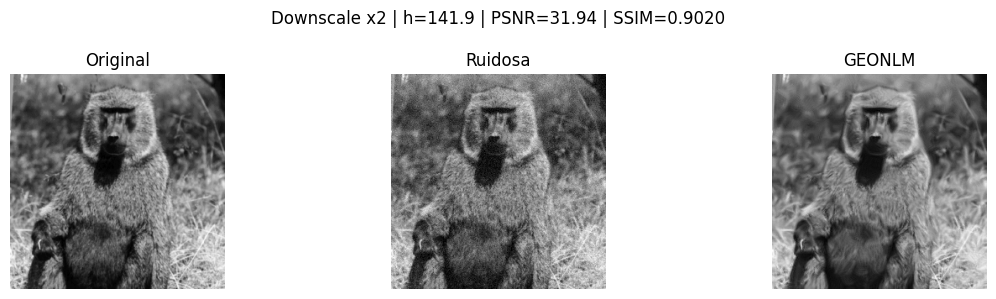

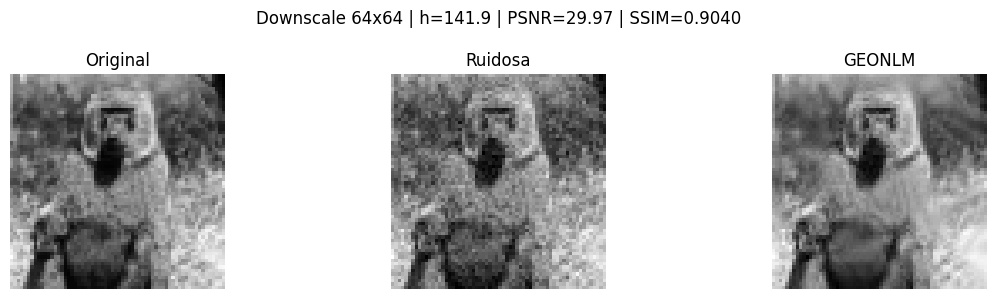

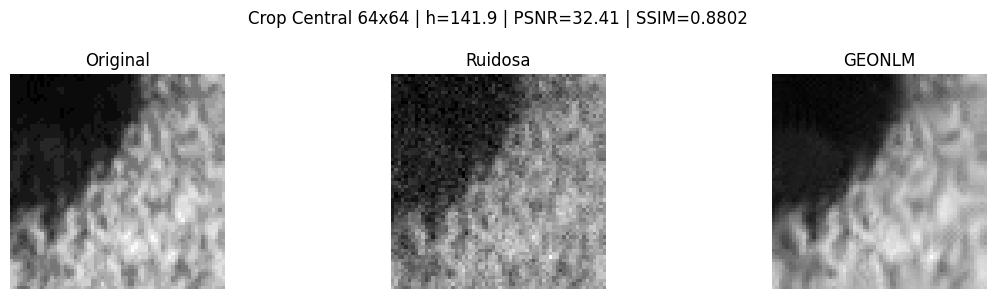

In [26]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/5.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.99, SSIM: 0.8875, Score: 60.87

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.92, SSIM: 0.8863, Score: 60.77

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.82, SSIM: 0.8843, Score: 60.63

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.70, SSIM: 0.8819, Score: 60.44

Executando GEONLM com h = 167.70 (base 129 * 1.3)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.57, SSIM: 0.8792, Score: 60.24

[FINAL] Melhor h: 141.90, PSNR: 32.99, SSIM: 0.8875

--- Executando Downscale 64x64 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 32.00, SSIM: 0.9151, Score: 61.75

Executando GEONLM com h = 148.35 (base 12

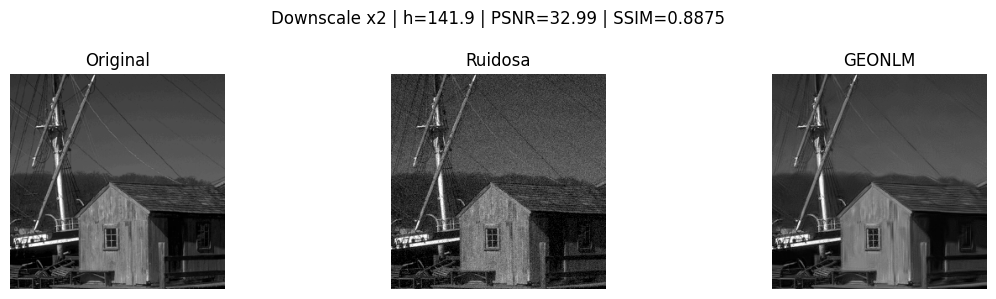

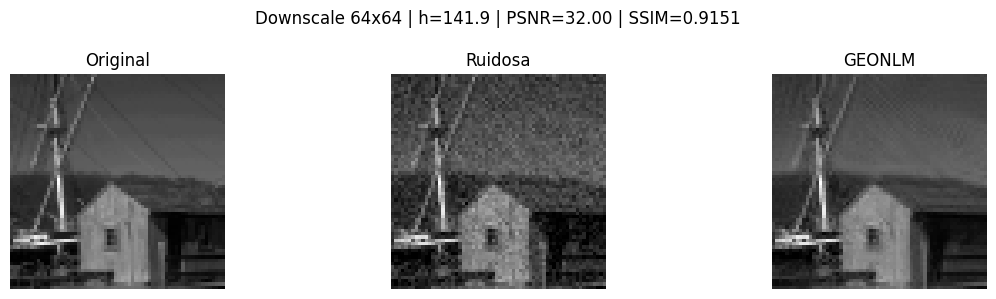

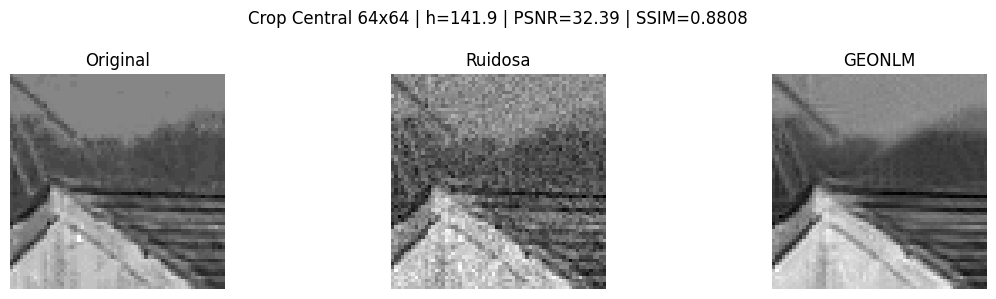

In [24]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/3.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.27, SSIM: 0.8874, Score: 60.51

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.18, SSIM: 0.8845, Score: 60.32

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.06, SSIM: 0.8810, Score: 60.08

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.91, SSIM: 0.8773, Score: 59.82

Executando GEONLM com h = 167.70 (base 129 * 1.3)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 31.75, SSIM: 0.8731, Score: 59.53

[FINAL] Melhor h: 141.90, PSNR: 32.27, SSIM: 0.8874

--- Executando Downscale 64x64 ---
q_nlm: 129, g_geo: 168

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 30.77, SSIM: 0.9173, Score: 61.25

Executando GEONLM com h = 148.35 (base 12

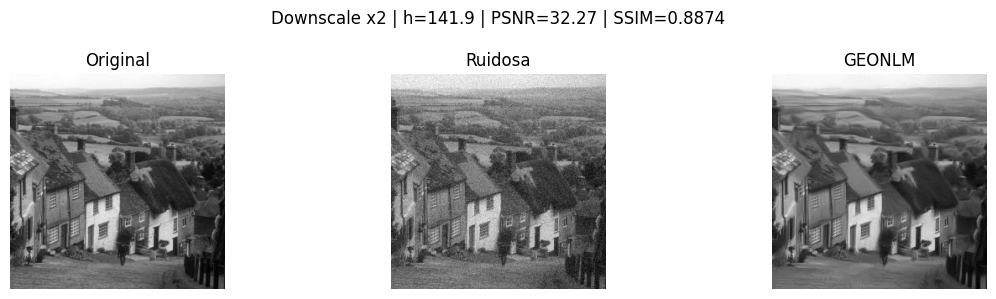

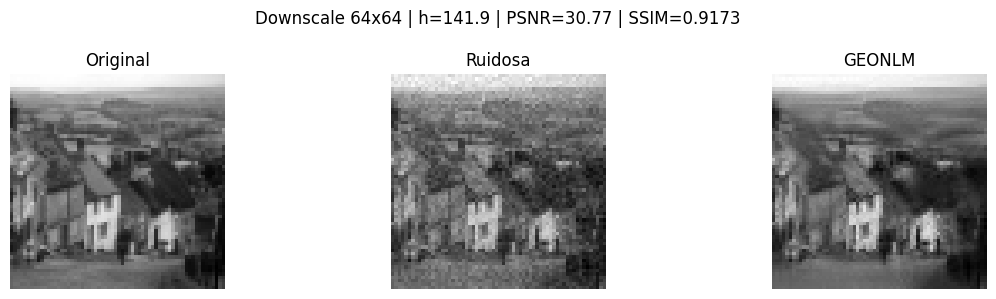

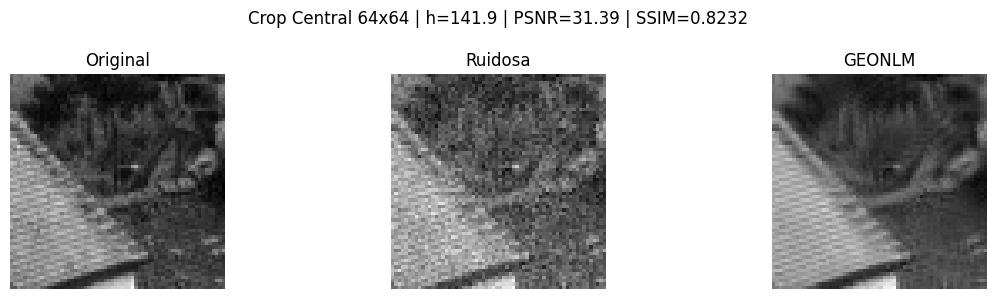

In [25]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/2.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()


--- Executando Downscale x2 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.13, SSIM: 0.9342, Score: 63.27

Executando GEONLM com h = 148.35 (base 129 * 1.15)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.13, SSIM: 0.9344, Score: 63.28

Executando GEONLM com h = 154.80 (base 129 * 1.2)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.08, SSIM: 0.9341, Score: 63.25

Executando GEONLM com h = 161.25 (base 129 * 1.25)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 33.01, SSIM: 0.9334, Score: 63.17

Executando GEONLM com h = 167.70 (base 129 * 1.3)
img_n.shape: (264, 264)
M: 256, N: 256
→ PSNR: 32.90, SSIM: 0.9323, Score: 63.07

[FINAL] Melhor h: 148.35, PSNR: 33.13, SSIM: 0.9344

--- Executando Downscale 64x64 ---
q_nlm: 129, g_geo: 169

Executando GEONLM com h = 141.90 (base 129 * 1.1)
img_n.shape: (72, 72)
M: 64, N: 64
→ PSNR: 30.57, SSIM: 0.9653, Score: 63.55

Executando GEONLM com h = 148.35 (base 12

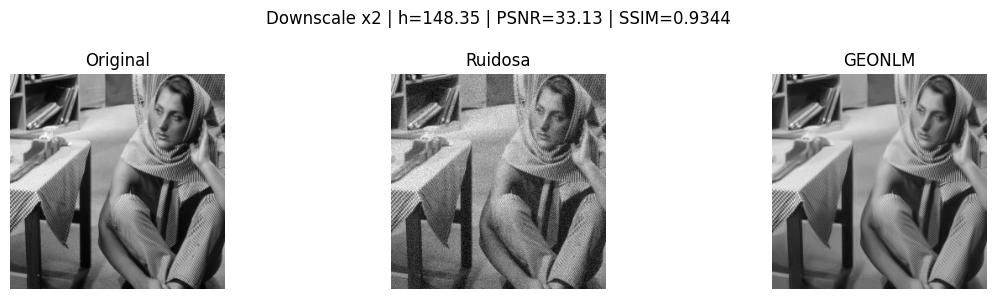

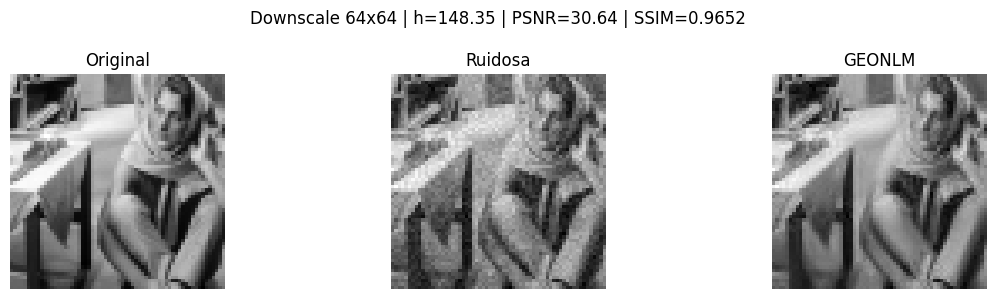

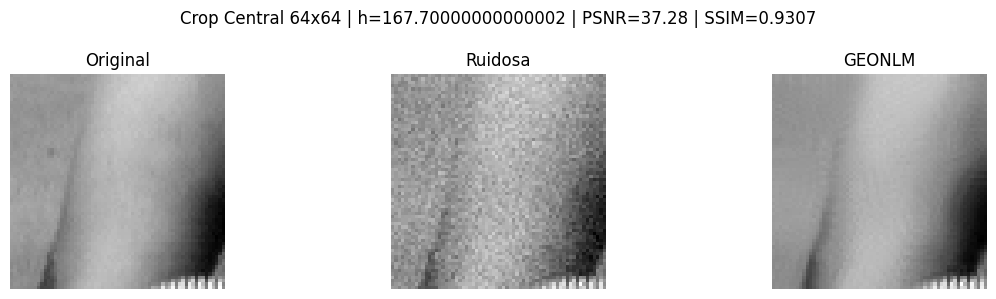

In [23]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# Carregamento
img_path = '../images/1.gif'
img = skimage.io.imread(img_path)
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img
img = img.astype(np.float32)

# Abordagens
originals = {
    "Downscale x2": downscale_local_mean(img, (2, 2)).astype(np.float32),
    "Downscale 64x64": downscale_to_64(img),
    "Crop Central 64x64": crop_center(img, (64, 64))
}

results = {}

for label, img_variant in originals.items():
    print(f"\n--- Executando {label} ---")
    img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val = run_single_pipeline(img_variant, f, t, nn)
    results[label] = (img_base, img_noisy, img_filtered, h_val, psnr_val, ssim_val)

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

for label, (original, noisy, filtered, h, psnr, ssim) in results.items():
    plt.figure(figsize=(12, 3))
    plt.suptitle(f"{label} | h={h} | PSNR={psnr:.2f} | SSIM={ssim:.4f}")
    plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(original.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noisy.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(filtered.astype(np.uint8), cmap='gray'); plt.axis('off')
    plt.tight_layout()
    plt.show()